## G2M insight for Cab Investment firm
### G2M Case Study
<b> Project detail:</b>
You have been provided with multiple data sets that contains information on 2 cab companies. Each file (data set) provided represents different aspects of the customer profile. XYZ is interested in using your actionable insights to help them identify the right company to make their investment.

The outcome of your delivery will be a presentation to XYZ’s Executive team. This presentation will be judged based on the visuals provided, the quality of your analysis and the value of your recommendations and insights.

#### Data Set:
You have been provided 4 individual data sets. Time period of data is from 31/01/2016 to 31/12/2018.

Below are the list of datasets which are provided for the analysis:

<b>Cab_Data.csv –</b> this file includes details of transaction for 2 cab companies

<b>Customer_ID.csv –</b> this is a mapping table that contains a unique identifier which links the customer’s demographic details

<b>Transaction_ID.csv –</b> this is a mapping table that contains transaction to customer mapping and payment mode

<b>City.csv –</b> this file contains list of US cities, their population and number of cab users

#### You should fully investigate and understand each data set.

Review the Source Documentation
Understand the field names and data types
Identify relationships across the files
Field/feature transformations
Determine which files should be joined versus which ones should be appended
Create master data and explain the relationship
Identify and remove duplicates
Perform other analysis like NA value and outlier detection

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pandasql import sqldf
from datetime import date, timedelta
from unidecode import unidecode

C:\Users\AMRAPALI\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read CSV Files

In [3]:
df_city = pd.read_csv("City.csv")
df_cab_data = pd.read_csv("Cab_Data.csv")
df_customer_id = pd.read_csv("Customer_ID.csv")
df_transaction_id = pd.read_csv("Transaction_ID.csv")

## Display data

In [4]:
df_city.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [5]:
df_cab_data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [6]:
df_customer_id.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [7]:
df_transaction_id.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


## Check NULL values

In [8]:
def renamecolumns(dataset):
    for col in dataset.columns:
        if ' ' in col:
            dataset = dataset.rename(columns={col:col.replace(' ','_')})
    return dataset

In [9]:
df_cab_data = renamecolumns(df_cab_data)
df_city = renamecolumns(df_city)
df_customer_id = renamecolumns(df_customer_id)
df_transaction_id = renamecolumns(df_transaction_id)

In [10]:
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    return total

In [11]:
missing_datas(df_cab_data)

Transaction_ID    0
Date_of_Travel    0
Company           0
City              0
KM_Travelled      0
Price_Charged     0
Cost_of_Trip      0
dtype: int64

In [12]:
missing_datas(df_city)

City          0
Population    0
Users         0
dtype: int64

In [13]:
missing_datas(df_customer_id)

Customer_ID           0
Gender                0
Age                   0
Income_(USD/Month)    0
dtype: int64

In [14]:
missing_datas(df_transaction_id)

Transaction_ID    0
Customer_ID       0
Payment_Mode      0
dtype: int64

## Display Numeric and Categoric Features

In [15]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

In [16]:
# display numeric and categorical features
def display_numeric_categoric_feature(dataset):
    numeric_columns = numeric_features(dataset)
    print("Numeric Features:")
    print(numeric_columns)
    print("===="*20)
    categorical_columns = categorical_features(dataset)
    print("Categorical Features:")
    print(categorical_columns)

In [17]:
display_numeric_categoric_feature(df_cab_data)

Numeric Features:
Index(['Transaction_ID', 'Date_of_Travel', 'KM_Travelled', 'Price_Charged',
       'Cost_of_Trip'],
      dtype='object')
Categorical Features:
Index(['Company', 'City'], dtype='object')


In [18]:
display_numeric_categoric_feature(df_city)

Numeric Features:
Index([], dtype='object')
Categorical Features:
Index(['City', 'Population', 'Users'], dtype='object')


In [19]:
display_numeric_categoric_feature(df_customer_id)

Numeric Features:
Index(['Customer_ID', 'Age', 'Income_(USD/Month)'], dtype='object')
Categorical Features:
Index(['Gender'], dtype='object')


In [20]:
display_numeric_categoric_feature(df_transaction_id)

Numeric Features:
Index(['Transaction_ID', 'Customer_ID'], dtype='object')
Categorical Features:
Index(['Payment_Mode'], dtype='object')


## Univariate analysis of Continuous columns

In [21]:
# Function to plot histograms
def plot_continuous_columns(dataframe):
    numeric_columns = numeric_features(dataframe)
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots
def plot_box_plots(dataframe):
    numeric_columns = numeric_features(dataframe)
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

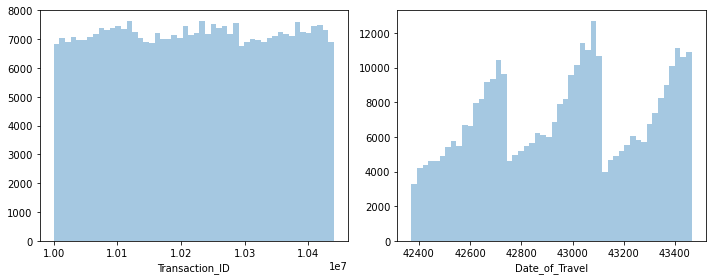

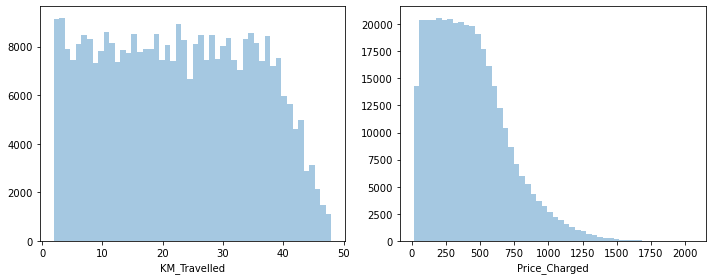

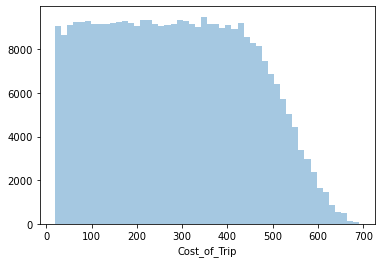

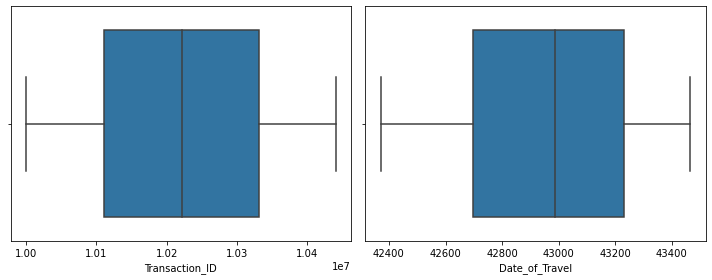

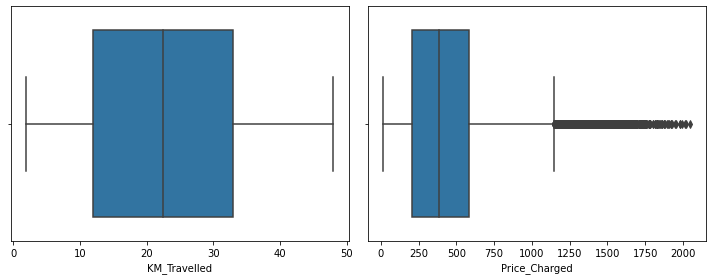

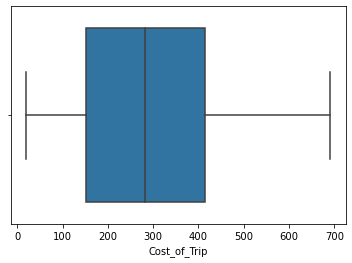

In [22]:
plot_continuous_columns(df_cab_data)            
plot_box_plots(df_cab_data)

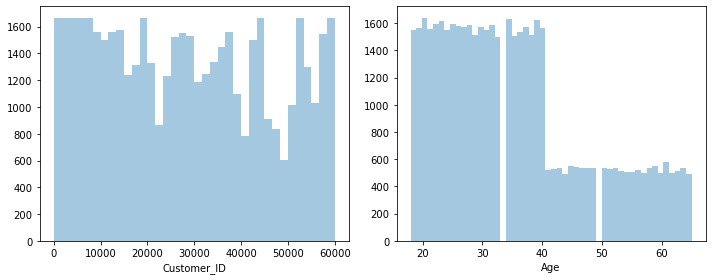

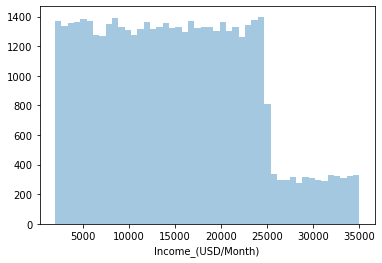

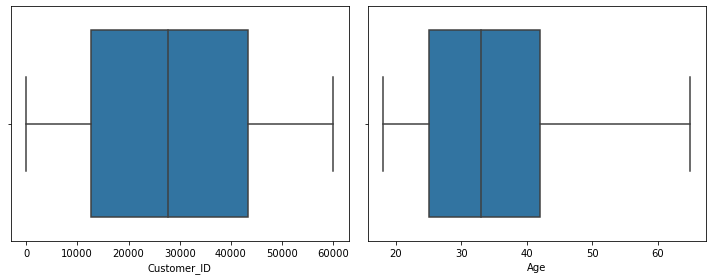

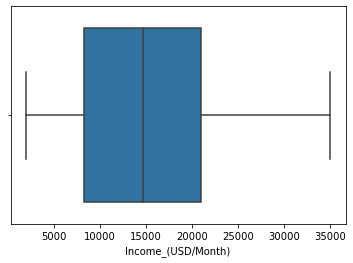

In [23]:
plot_continuous_columns(df_customer_id)            
plot_box_plots(df_customer_id)

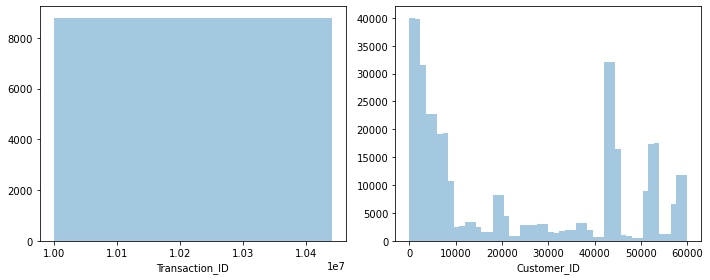

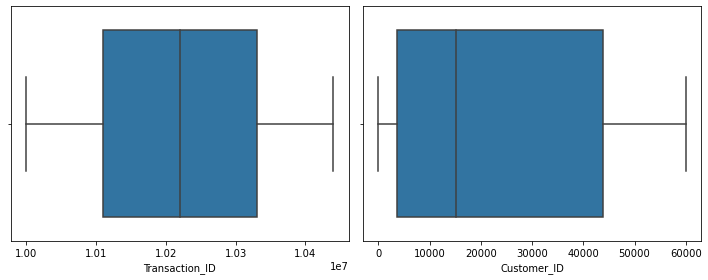

In [24]:
plot_continuous_columns(df_transaction_id)            
plot_box_plots(df_transaction_id)

## EDA

In [25]:
PinkCab = df_cab_data[df_cab_data['Company']=='Pink Cab']
YellowCab = df_cab_data[df_cab_data['Company']=='Yellow Cab']

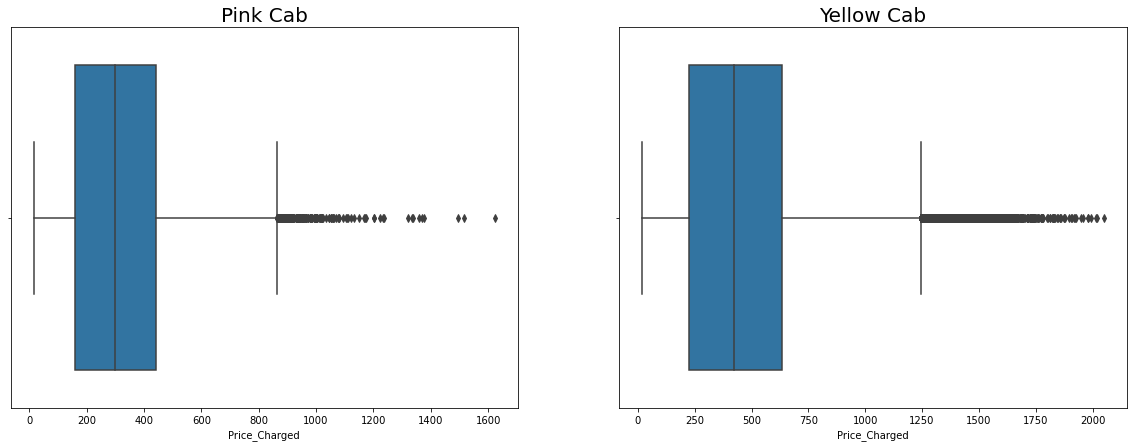

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7))
sns.boxplot(PinkCab['Price_Charged'], ax=ax1)
ax1.set_title('Pink Cab', fontsize=20)
sns.boxplot(YellowCab['Price_Charged'], ax=ax2)
ax2.set_title('Yellow Cab', fontsize=20)
plt.show()

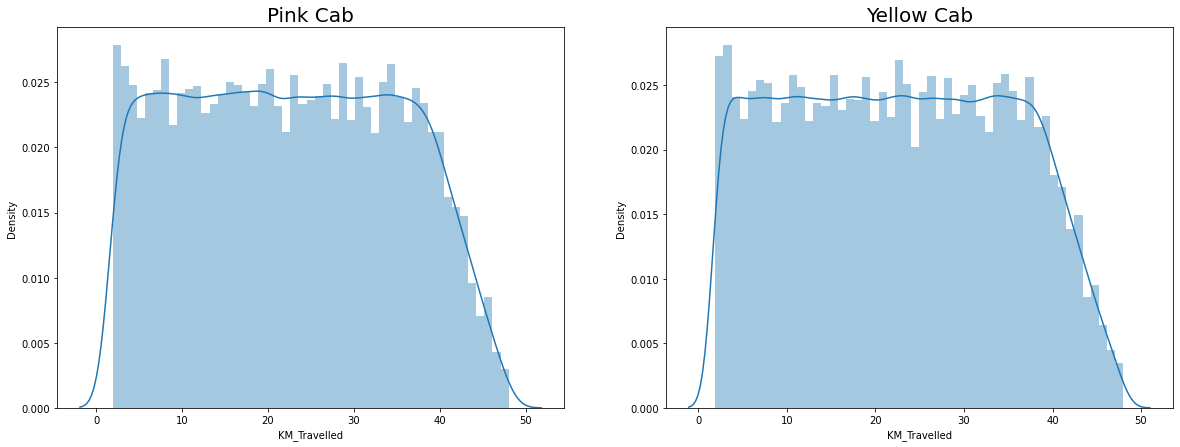

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7))
sns.distplot(PinkCab['KM_Travelled'], ax=ax1)
ax1.set_title('Pink Cab', fontsize=20)
sns.distplot(YellowCab['KM_Travelled'], ax=ax2)
ax2.set_title('Yellow Cab', fontsize=20)
plt.show()

## Analysis

## 1. Profit Analysis

In [28]:
df_cab_data['Date_of_Travel'] = df_cab_data['Date_of_Travel'].apply(lambda x:date(1899,12,30) + timedelta(days=x))
df_cab_data['Date_of_Travel'].head()

0    2016-01-08
1    2016-01-06
2    2016-01-02
3    2016-01-07
4    2016-01-03
Name: Date_of_Travel, dtype: object

In [29]:
df_cab_data['Date_of_Travel'].describe()

count         359392
unique          1095
top       2018-01-05
freq            2022
Name: Date_of_Travel, dtype: object

In [30]:
df_cab_data['Date_of_Travel'] = pd.to_datetime(df_cab_data['Date_of_Travel'])

In [31]:
df_cab_data['year'], df_cab_data['month'], df_cab_data['day'] = df_cab_data['Date_of_Travel'].dt.year, df_cab_data['Date_of_Travel'].dt.month, df_cab_data['Date_of_Travel'].dt.day

In [32]:
df_cab_data['year'].unique

<bound method Series.unique of 0         2016
1         2016
2         2016
3         2016
4         2016
          ... 
359387    2018
359388    2018
359389    2018
359390    2018
359391    2018
Name: year, Length: 359392, dtype: int64>

In [33]:
df_cab_data['profit'] = round((df_cab_data['Price_Charged'] - df_cab_data['Cost_of_Trip']),2)
df_cab_data['avg_profit'] = round(((df_cab_data['Price_Charged'] - df_cab_data['Cost_of_Trip'])/df_cab_data['KM_Travelled']),2)

In [34]:
df_cab_data.head()

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,year,month,day,profit,avg_profit
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,2016,1,8,57.32,1.88
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,2016,1,6,23.67,0.83
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,2016,1,2,27.57,3.05
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,2016,1,7,25.80,0.78
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,2016,1,3,16.84,1.93


In [35]:
profit_year = pd.pivot_table(data = df_cab_data, index=['year'], columns= ['Company'], values = ['avg_profit'], aggfunc=np.average)

In [36]:
profit_year['avg_profit'] = round(profit_year['avg_profit'],2)

In [37]:
profit_year.head()

avg_profit           
Company   Pink Cab Yellow Cab
year                         
2016          3.03       7.49
2017          2.96       7.49
2018          2.35       6.36

Text(0.5, 1.0, 'Average Profit Yearly')

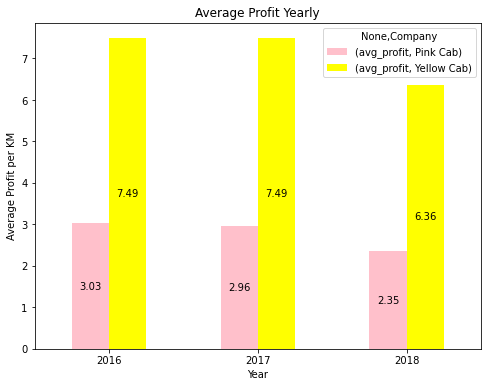

In [38]:
colors = ['pink','yellow']
ax = profit_year.plot(kind='bar',color=colors,  figsize=(8, 6), rot=0, xlabel='Year', ylabel='Average Profit per KM')
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
ax.set_title("Average Profit Yearly")    

In [39]:
profit_month = pd.pivot_table(data = df_cab_data, index=['month'], columns= ['Company'], values = ['avg_profit'], aggfunc=np.average)

In [40]:
profit_month['avg_profit'] = round(profit_month['avg_profit'],2)

In [41]:
#profit_month = profit_month[profit_month['avg_profit','year'] == 2016]

Text(0.5, 1.0, 'Average Profit Monthly')

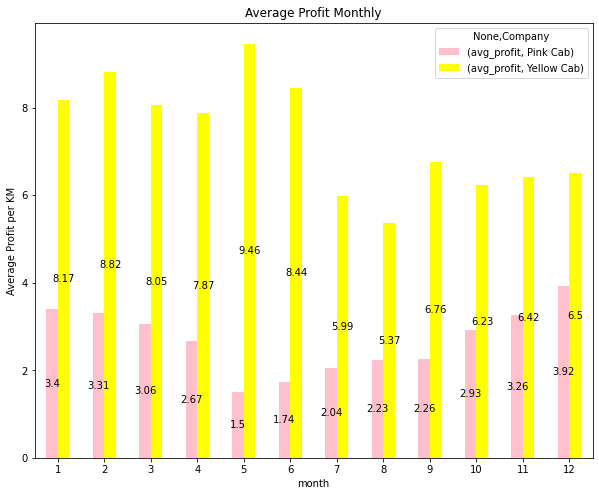

In [42]:
colors = ['pink','yellow']
ax = profit_month.plot(kind='bar',color = colors, figsize=(10, 8), rot=0, xlabel='month', ylabel='Average Profit per KM')
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
ax.set_title("Average Profit Monthly")       

In [43]:
profit_city = pd.pivot_table(data = df_cab_data, index=['City'], columns= ['Company'], values = ['avg_profit'], aggfunc=np.average)
profit_city = profit_city.reindex(profit_city['avg_profit'].sort_values(by=['Yellow Cab'], ascending=False).index) 

In [44]:
profit_city.columns

MultiIndex([('avg_profit',   'Pink Cab'),
            ('avg_profit', 'Yellow Cab')],
           names=[None, 'Company'])

In [45]:
profit_city.head()

avg_profit           
Company          Pink Cab Yellow Cab
City                                
NEW YORK NY      4.790455  13.680693
SILICON VALLEY   3.898375   9.046874
DALLAS TX        0.825203   8.659785
DENVER CO        1.275983   6.538268
ORANGE COUNTY    3.009061   6.439275

In [46]:
profit_city['avg_profit'] = round(profit_city['avg_profit'],2)

Text(0.5, 1.0, 'Citywise Average Profit ')

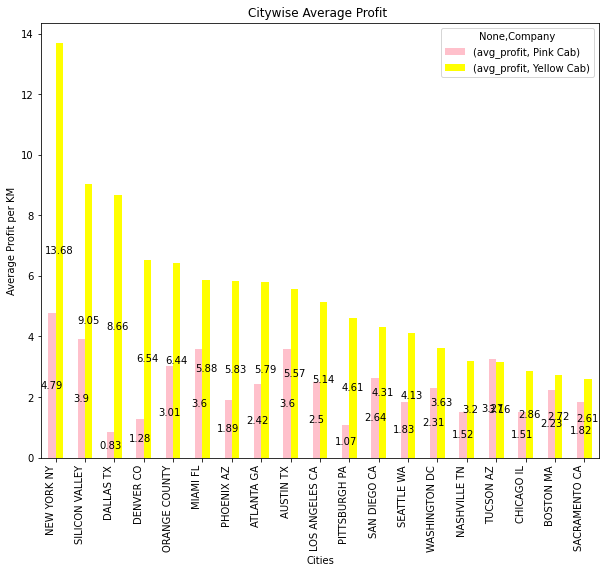

In [47]:
colors = ['pink','yellow']
ax = profit_city.plot(kind='bar',color = colors,  figsize=(10, 8), rot=0, xlabel='Cities', ylabel='Average Profit per KM')
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
plt.xticks(rotation=90, ha='right')
ax.set_title("Citywise Average Profit ")   

In [48]:
profit_year_trend = pd.pivot_table(data = df_cab_data, index=['year'], columns= ['Company'],values = ['profit'], aggfunc=np.sum)

In [49]:
profit_year_trend.head()

profit             
Company    Pink Cab   Yellow Cab
year                            
2016     1713511.27  13926996.40
2017     2033655.24  16575977.40
2018     1560162.00  13517398.79

Text(0.5, 1.0, 'Yearly Total Profit ')

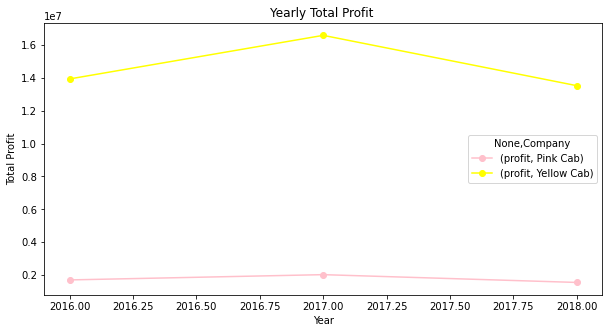

In [50]:
colors = ['pink','yellow']
ax = profit_year_trend.plot(kind='line',color = colors,  figsize=(10, 5), rot=0, xlabel='Year', ylabel='Total Profit',style='.-', marker='o')
ax.set_title("Yearly Total Profit ")   

### Genderwise Profit Analysis

In [51]:
query = """
         SELECT * 
        FROM df_cab_data 
        JOIN df_transaction_id 
        USING(Transaction_ID)
        JOIN df_customer_id
        USING(Customer_ID)
        JOIN df_city
        USING(City)
        
        ;

"""

Master_data = sqldf(query)

In [52]:
Master_data.head()

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,year,month,day,profit,avg_profit,Customer_ID,Payment_Mode,Gender,Age,Income_(USD/Month),Population,Users
0,10000011,2016-01-08 00:00:00.000000,Pink Cab,ATLANTA GA,30.45,370.95,313.635,2016,1,8,57.32,1.88,29290,Card,Male,28,10813,"814,885","24,701"
1,10000012,2016-01-06 00:00:00.000000,Pink Cab,ATLANTA GA,28.62,358.52,334.854,2016,1,6,23.67,0.83,27703,Card,Male,27,9237,"814,885","24,701"
2,10000013,2016-01-02 00:00:00.000000,Pink Cab,ATLANTA GA,9.04,125.20,97.632,2016,1,2,27.57,3.05,28712,Cash,Male,53,11242,"814,885","24,701"
3,10000014,2016-01-07 00:00:00.000000,Pink Cab,ATLANTA GA,33.17,377.40,351.602,2016,1,7,25.80,0.78,28020,Cash,Male,23,23327,"814,885","24,701"
4,10000015,2016-01-03 00:00:00.000000,Pink Cab,ATLANTA GA,8.73,114.62,97.776,2016,1,3,16.84,1.93,27182,Card,Male,33,8536,"814,885","24,701"


In [53]:
profit_gender = pd.pivot_table(data = Master_data, index=['year'], columns= ['Company','Gender'],values = ['avg_profit'], aggfunc=np.average)

In [54]:
profit_gender = round(profit_gender,2)

In [55]:
profit_gender.head()

avg_profit                       
Company   Pink Cab       Yellow Cab      
Gender      Female  Male     Female  Male
year                                     
2016          2.99  3.05       7.30  7.63
2017          2.94  2.98       7.34  7.61
2018          2.34  2.36       6.22  6.47

Text(0.5, 1.0, 'Genderwise Average Profit ')

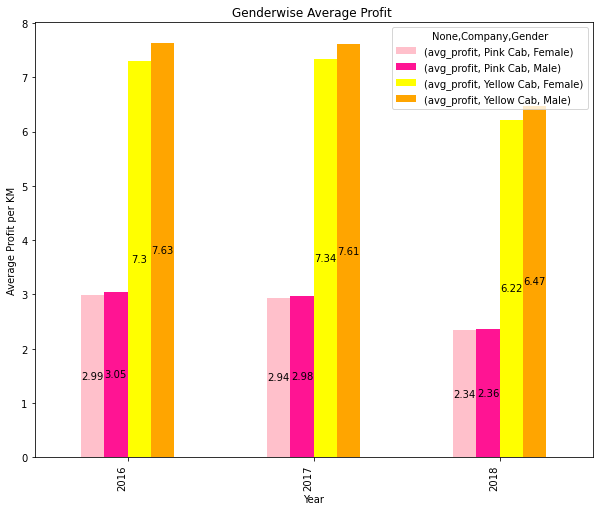

In [56]:
colors = ['pink','deeppink','yellow','orange']
ax = profit_gender.plot(kind='bar',color = colors, figsize=(10, 8), rot=0, xlabel='Year', ylabel='Average Profit per KM')
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
plt.xticks(rotation=90, ha='right')
ax.set_title("Genderwise Average Profit ")   

## Agewise total Profit

In [57]:
binlabels = ['18-25','26-40','41-59','60+']
Master_data['age_bin']  = pd.cut(Master_data['Age'],[18,26,41,60,150],labels = binlabels)

In [58]:
profit_age = pd.pivot_table(data = Master_data, index=['year'], columns= ['Company','age_bin'],values = ['avg_profit'], aggfunc=np.sum)
profit_age = profit_age.sort_values([('avg_profit', 'Yellow Cab', '18-25')], ascending=False)

In [59]:
profit_age.columns

MultiIndex([('avg_profit',   'Pink Cab', '18-25'),
            ('avg_profit',   'Pink Cab', '26-40'),
            ('avg_profit',   'Pink Cab', '41-59'),
            ('avg_profit',   'Pink Cab',   '60+'),
            ('avg_profit', 'Yellow Cab', '18-25'),
            ('avg_profit', 'Yellow Cab', '26-40'),
            ('avg_profit', 'Yellow Cab', '41-59'),
            ('avg_profit', 'Yellow Cab',   '60+')],
           names=[None, 'Company', 'age_bin'])

In [60]:
profit_age = round(profit_age,2)

In [61]:
profit_age.head()

avg_profit                                                     \
Company   Pink Cab                              Yellow Cab              
age_bin      18-25     26-40     41-59      60+      18-25      26-40   
year                                                                    
2017      24412.60  39404.61  18287.21  4753.71  192471.48  331281.43   
2016      19605.79  34231.18  15397.05  4237.97  160290.78  280119.99   
2018      18494.55  30965.98  13866.21  3526.74  157261.85  270461.16   

                              
Company                       
age_bin      41-59       60+  
year                          
2017     152349.95  37066.07  
2016     125988.60  30747.68  
2018     124730.39  29965.13

Text(0.5, 1.0, 'Agewise Total Profit ')

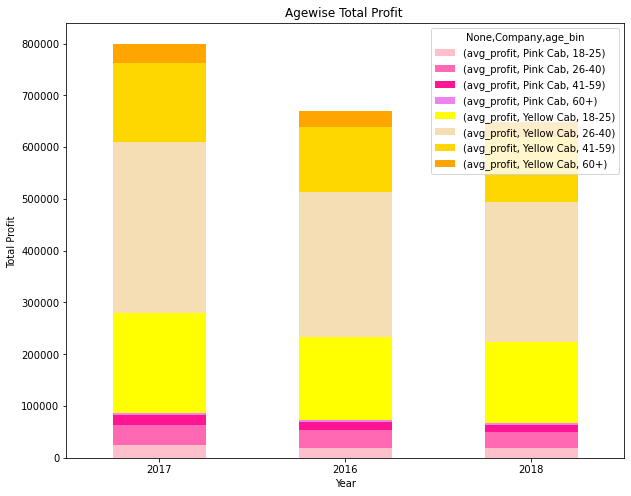

In [62]:
colors = ['pink','hotpink','deeppink','violet','yellow','wheat','gold','orange']
ax = profit_age.plot(kind='bar',color = colors, stacked = True,figsize=(10, 8), rot=0, xlabel='Year', ylabel='Total Profit ')

ax.set_title("Agewise Total Profit ") 

### Incomewise total Profit

In [63]:
binlabels = ['Low','Middle','High']
Master_data['income_bin']  = pd.cut(Master_data['Income_(USD/Month)'],[0,2500,15000,35000],labels = binlabels)

In [64]:
Master_data.head()

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,year,month,day,...,avg_profit,Customer_ID,Payment_Mode,Gender,Age,Income_(USD/Month),Population,Users,age_bin,income_bin
0,10000011,2016-01-08 00:00:00.000000,Pink Cab,ATLANTA GA,30.45,370.95,313.635,2016,1,8,...,1.88,29290,Card,Male,28,10813,"814,885","24,701",26-40,Middle
1,10000012,2016-01-06 00:00:00.000000,Pink Cab,ATLANTA GA,28.62,358.52,334.854,2016,1,6,...,0.83,27703,Card,Male,27,9237,"814,885","24,701",26-40,Middle
2,10000013,2016-01-02 00:00:00.000000,Pink Cab,ATLANTA GA,9.04,125.20,97.632,2016,1,2,...,3.05,28712,Cash,Male,53,11242,"814,885","24,701",41-59,Middle
3,10000014,2016-01-07 00:00:00.000000,Pink Cab,ATLANTA GA,33.17,377.40,351.602,2016,1,7,...,0.78,28020,Cash,Male,23,23327,"814,885","24,701",18-25,High
4,10000015,2016-01-03 00:00:00.000000,Pink Cab,ATLANTA GA,8.73,114.62,97.776,2016,1,3,...,1.93,27182,Card,Male,33,8536,"814,885","24,701",26-40,Middle


In [65]:
profit_income = pd.pivot_table(data = Master_data, index=['year'], columns= ['Company','income_bin'],values = ['avg_profit'], aggfunc=np.sum)
#profit_age = profit_age.sort_values([('avg_profit', 'Yellow Cab', 'Low')], ascending=False)

In [66]:
profit_income = round(profit_income,2)

In [67]:
profit_income.head()

avg_profit                                                     
Company      Pink Cab                     Yellow Cab                      
income_bin        Low    Middle      High        Low     Middle       High
year                                                                      
2016          1480.26  36346.32  38085.66   11231.44  300754.60  303970.35
2017          1814.20  44071.64  43951.91   14390.35  357510.24  363986.18
2018          1490.57  33770.36  33630.76   11491.43  291640.00  296770.97

Text(0.5, 1.0, 'Incomewise Total Profit ')

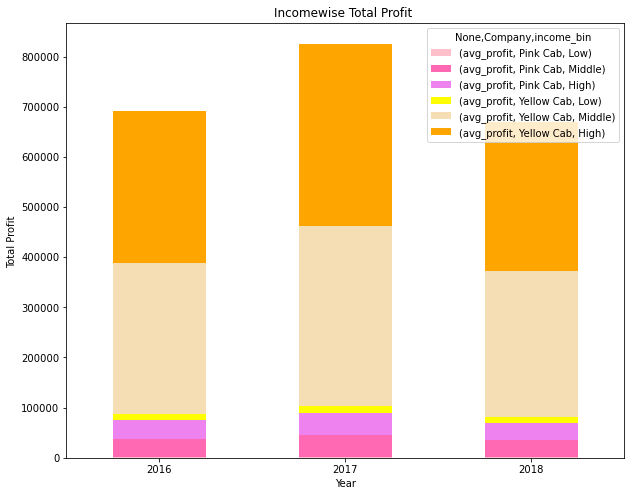

In [68]:
colors = ['pink','hotpink','violet','yellow','wheat','orange']
ax = profit_income.plot(kind='bar',color = colors, stacked = True,figsize=(10, 8), rot=0, xlabel='Year', ylabel='Total Profit ')

ax.set_title("Incomewise Total Profit ") 

In [69]:
profit_income_month = pd.pivot_table(data = Master_data, index=['month'], columns= ['Company','income_bin'],values = ['avg_profit'], aggfunc=np.sum)

In [70]:
profit_income_month = round(profit_income_month,2)

Text(0.5, 1.0, 'Incomewise Total Profit ')

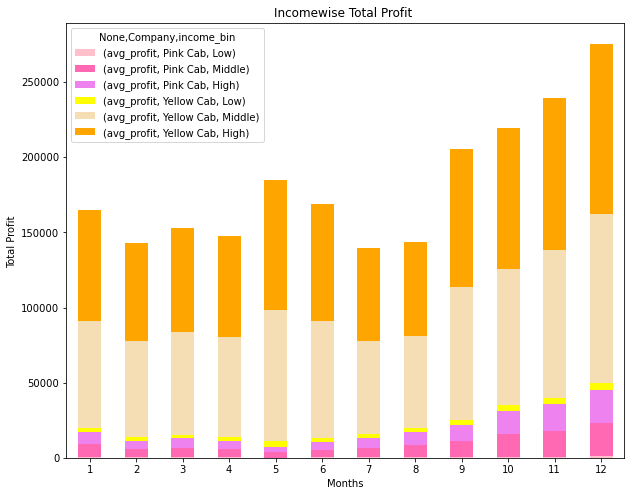

In [71]:
colors = ['pink','hotpink','violet','yellow','wheat','orange']
ax = profit_income_month.plot(kind='bar',color = colors, stacked = True,figsize=(10, 8), rot=0, xlabel='Months', ylabel='Total Profit ')

ax.set_title("Incomewise Total Profit ") 

### Customer Retention 

In [72]:
query = """
        SELECT Customer_ID,Company, year, COUNT(Transaction_ID) AS Rides
        FROM Master_data
        GROUP BY 1,2,3
        HAVING Rides > 10
        ORDER BY 4
        
        ;

"""

df2 = sqldf(query)

In [73]:
df2.tail()

,Customer_ID,Company,year,Rides
3559,1198,Yellow Cab,2017,21
3560,1821,Yellow Cab,2018,21
3561,270,Yellow Cab,2018,22
3562,2079,Yellow Cab,2017,22
3563,1766,Yellow Cab,2017,25


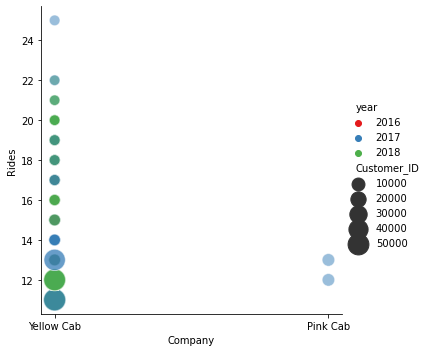

In [74]:
sns.relplot(x="Company", y="Rides",
            hue="year", size="Customer_ID", sizes=(100,500),
            palette="Set1", alpha=0.5,
            data=df2);

## Citywise Users

In [75]:
Master_data['Users'] = Master_data['Users'].apply(lambda x: (unidecode(x).replace(',','')))

In [76]:
Master_data['Users']

0           24701 
1           24701 
2           24701 
3           24701 
4           24701 
            ...   
359387     127001 
359388     127001 
359389     127001 
359390     127001 
359391     127001 
Name: Users, Length: 359392, dtype: object

In [77]:
Master_data['Users'] = pd.to_numeric(Master_data['Users'])

In [78]:
city_users = pd.pivot_table(data = Master_data, index=['City'], columns= ['Company'],values = ['Users'], aggfunc=np.average)
city_users = city_users.sort_values([('Users', 'Yellow Cab')], ascending=False)

In [79]:
city_users.head()

Users           
Company        Pink Cab Yellow Cab
City                              
NEW YORK NY      302149     302149
CHICAGO IL       164468     164468
LOS ANGELES CA   144132     144132
WASHINGTON DC    127001     127001
BOSTON MA         80021      80021

Text(0.5, 1.0, 'Citywise Total Users ')

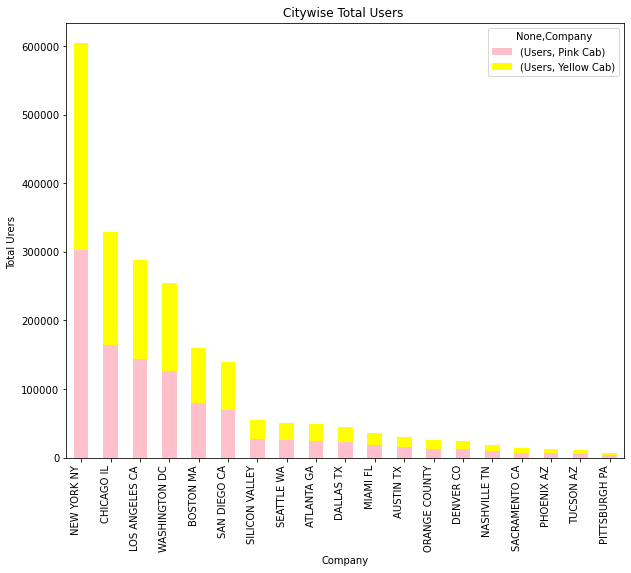

In [80]:
colors = ['pink','yellow']
ax = city_users.plot(kind='bar',color = colors, stacked = True,figsize=(10, 8), rot=0, xlabel='Company', ylabel='Total Urers ')

plt.xticks(rotation=90, ha='right')
ax.set_title("Citywise Total Users ") 

### Seasonabilty 

In [81]:
query = """
        SELECT day, Company, COUNT(Transaction_ID) AS daily_rides, AVG(Users) AS daily_users
        FROM Master_data
        GROUP BY 1, 2
        ORDER BY 3
        
        ;

"""

daily_users = sqldf(query)

In [82]:
daily_users.head()

,day,Company,daily_rides,daily_users
0,31,Pink Cab,1541,122445.436080
1,11,Pink Cab,2365,123216.461734
2,25,Pink Cab,2447,125931.079281
3,30,Pink Cab,2537,122013.447773
4,18,Pink Cab,2556,130157.973005


Text(0.5, 1.0, 'Daily Rides ')

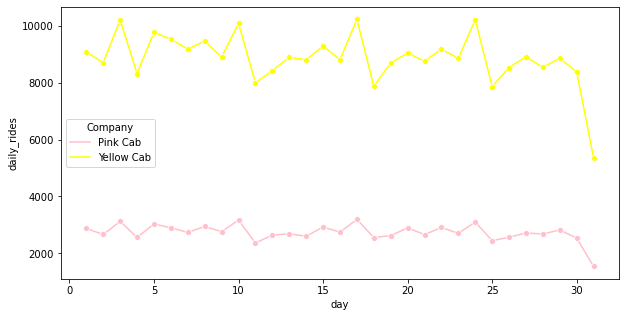

In [83]:
plt.figure(figsize=(10,5))
colors = ['pink','yellow']
sns.lineplot( data = daily_users,x= 'day', y = 'daily_rides', hue = 'Company', palette = colors, marker="o")


ax.set_title("Daily Rides ") 

### Daily Users

In [84]:
users_daily = pd.pivot_table(data = Master_data, index=['day'], columns= ['Company'],values = ['Users'], aggfunc=np.sum)
#users_daily = users_daily.sort_values([('Users', 'Yellow Cab')], ascending=False)

In [85]:
users_daily.head()

Users            
Company   Pink Cab  Yellow Cab
day                           
1        357571965  1516278781
2        327068580  1448447366
3        397829988  1731041909
4        313198212  1404860426
5        368629034  1658128295

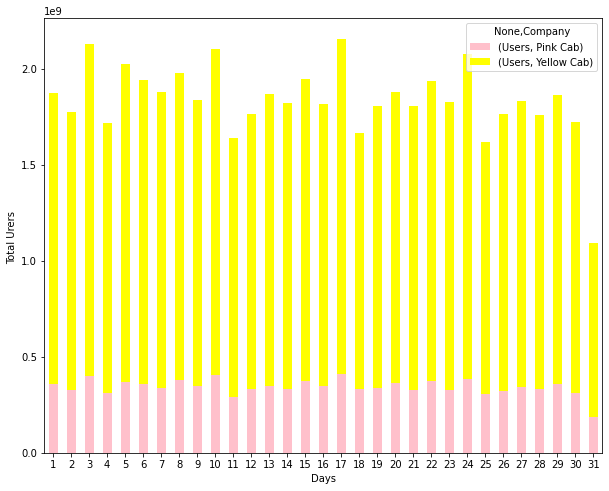

In [86]:
colors = ['pink','yellow']
ax = users_daily.plot(kind='bar',color = colors, stacked = True,figsize=(10, 8), rot=0, xlabel='Days', ylabel='Total Urers ')
#ax.set_title("Total Daily Users ") 

### Distance in KM Travelled

In [87]:
binlabels = ['Short',"Middle",'Long']
Master_data['distance_bin']  = pd.cut(Master_data['KM_Travelled'],[0,5,30,50],labels = binlabels)

In [88]:
users_distance = pd.pivot_table(data = Master_data, index=['distance_bin'], columns= ['Company'],values = ['Users'], aggfunc=np.sum)
users_distance = users_distance.sort_values([('Users', 'Yellow Cab')], ascending=False)

In [89]:
users_distance.head()

Users             
Company         Pink Cab   Yellow Cab
distance_bin                         
Middle        6371882544  27793724687
Long          3396848362  14645321532
Short          870192482   3837353735

Text(0.5, 1.0, 'Distancewise user distribution ')

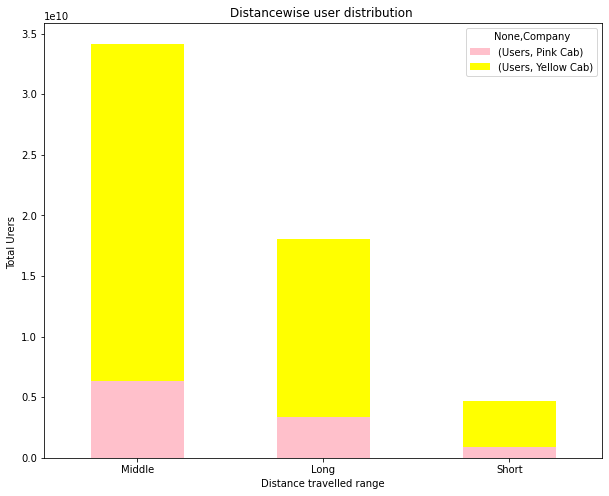

In [90]:
colors = ['pink','yellow']
ax = users_distance.plot(kind='bar',color = colors, stacked = True,figsize=(10, 8), rot=0, xlabel='Distance travelled range', ylabel='Total Urers ')

ax.set_title("Distancewise user distribution ") 

## Hypothesis Testing

### Hypothesis : Is there profit remains same for gender for yellow & pink cab?

#### Null Hypothesis:Profit for Gender remains same for Yellow Cab & Pink Cab

<b>for yellow cab</b>

In [93]:
female = Master_data[(Master_data['Gender']=='Female')&(Master_data['Company']=='Yellow Cab')].groupby('Transaction_ID')['profit'].mean()
male = Master_data[(Master_data['Gender']=='Male')&(Master_data['Company']=='Yellow Cab')].groupby('Transaction_ID')['profit'].mean()
print(female.shape[0],male.shape[0])

from scipy import stats
_, p_value = stats.ttest_ind(female.values,male.values,equal_var=True)
if(p_value<0.05):
    print('We accept alternate hypothesis that there is a statistical difference')
else:
    print('We accept null hypothesis that there is no statistical difference')
    
print('P value is ', p_value)

116000 158681
We accept alternate hypothesis that there is a statistical difference
P value is  6.061440146232034e-25


  <b>Yellow Cab:</b> There is difference in Profit between Male and Female customers

<b>for Pink cab</b>

In [95]:
female = Master_data[(Master_data['Gender']=='Female')&(Master_data['Company']=='Pink Cab')].groupby('Transaction_ID')['profit'].mean()
male = Master_data[(Master_data['Gender']=='Male')&(Master_data['Company']=='Pink Cab')].groupby('Transaction_ID')['profit'].mean()
print(female.shape[0],male.shape[0])

from scipy import stats
_, p_value = stats.ttest_ind(female.values,male.values,equal_var=True)
if(p_value<0.05):
    print('We accept alternate hypothesis that there is a statistical difference')
else:
    print('We accept null hypothesis that there is no statistical difference')
    
print('P value is ', p_value)

37480 47231
We accept null hypothesis that there is no statistical difference
P value is  0.11516186231099297


<b>Pink Cab:</b> There is no difference in profit between Male and Female customers

### Hypothesis : Is there difference in profit for Card payers and Cash payers?

#### Null Hypothesis : Profit remains same for card and cash payers

In [98]:
# Pink cab
cash = Master_data[(Master_data['Payment_Mode']=='Cash')&(Master_data['Company']=='Pink Cab')].groupby('Transaction_ID')['profit'].mean()
card = Master_data[(Master_data['Payment_Mode']=='Card')&(Master_data['Company']=='Pink Cab')].groupby('Transaction_ID')['profit'].mean()
print(female.shape[0],male.shape[0])

from scipy import stats
_, p_value = stats.ttest_ind(cash.values,card.values,equal_var=True)
if(p_value<0.05):
    print('We accept alternate hypothesis that there is a statistical difference')
else:
    print('We accept null hypothesis that there is no statistical difference')
    
print('P value is ', p_value)

37480 47231
We accept null hypothesis that there is no statistical difference
P value is  0.7900091959151682


#### Pink Cab: There is no difference in profit for cash and card users

In [99]:
# Yelllow cab
cash = Master_data[(Master_data['Payment_Mode']=='Cash')&(Master_data['Company']=='Yellow Cab')].groupby('Transaction_ID')['profit'].mean()
card = Master_data[(Master_data['Payment_Mode']=='Card')&(Master_data['Company']=='Yellow Cab')].groupby('Transaction_ID')['profit'].mean()
print(female.shape[0],male.shape[0])

from scipy import stats
_, p_value = stats.ttest_ind(cash.values,card.values,equal_var=True)
if(p_value<0.05):
    print('We accept alternate hypothesis that there is a statistical difference')
else:
    print('We accept null hypothesis that there is no statistical difference')
    
print('P value is ', p_value)

37480 47231
We accept null hypothesis that there is no statistical difference
P value is  0.2933058137696317


#### Yellow Cab: There is no difference in profit for cash and card users